In [11]:
import os
from pathlib import Path

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [12]:
DATA_DIR = Path("data")
MASKS_DIR = DATA_DIR / "car_masks"
IMAGES_DIR = DATA_DIR / "images"
SHADOWS_DIR = DATA_DIR / "shadow_masks"

masks = list(MASKS_DIR.glob("*.png"))
images = list(IMAGES_DIR.glob("*.jpeg"))
shadow_masks = list(SHADOWS_DIR.glob("*.png"))

print(f"Number of masks: {len(masks)}")
print(f"Number of images: {len(images)}")
print(f"Number of shadow masks: {len(shadow_masks)}")

Number of masks: 6
Number of images: 6
Number of shadow masks: 6


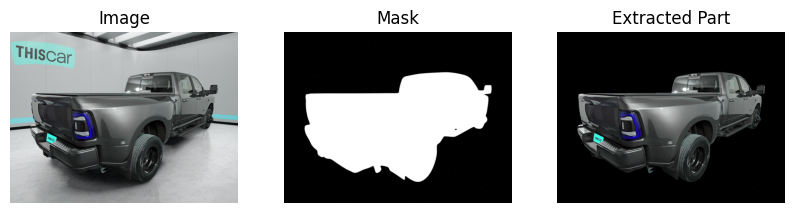

In [13]:
def show_image_and_mask(image_id):
    image_path = IMAGES_DIR / f"{image_id}.jpeg"
    mask_path = MASKS_DIR / f"{image_id}.png"

    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    extracted_part = cv2.bitwise_and(image, image, mask=mask)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(extracted_part)
    plt.title("Extracted Part")
    plt.axis("off")

    plt.show()


show_image_and_mask(1)

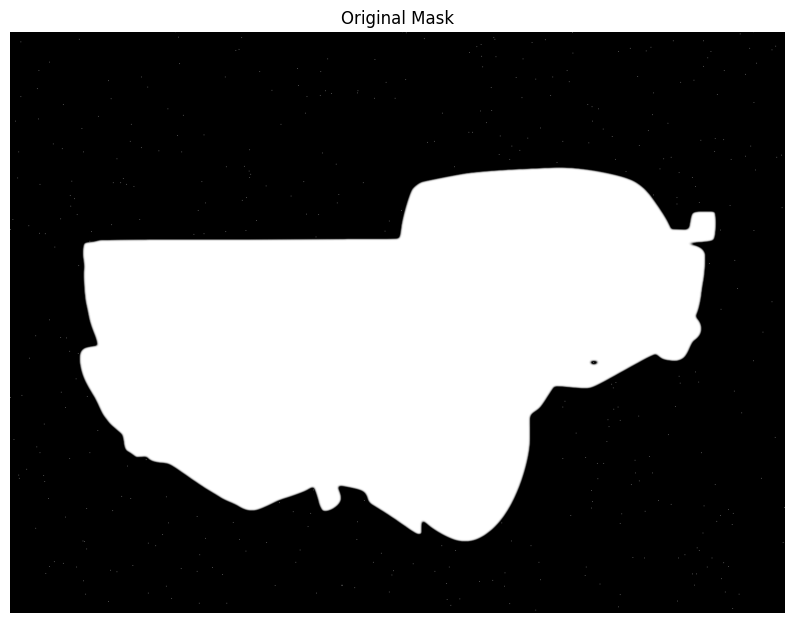

In [14]:
plt.figure(figsize=(10,10))
original_mask = plt.imread(MASKS_DIR/"1.png")
plt.imshow(original_mask, cmap='gray')
plt.title("Original Mask")
plt.axis("off")
plt.show()

In [15]:
print(original_mask.shape)

(1095, 1460)


In [16]:
def clean_mask(mask, kernel_size=10):
    _, mask = cv2.threshold(mask, 0.498, 1, cv2.THRESH_BINARY)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.medianBlur(mask, ksize=5)
    return mask

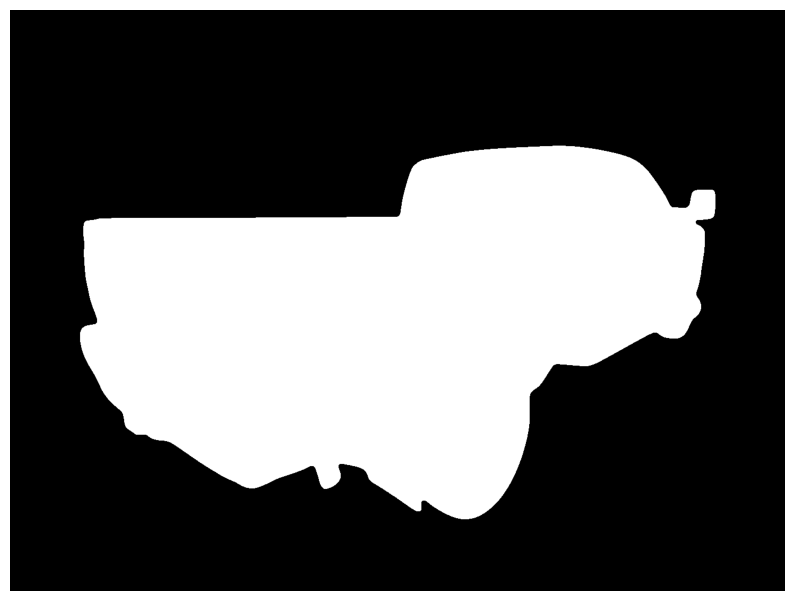

In [17]:
plt.figure(figsize=(10,10))
opened_mask = clean_mask(original_mask, 7)
plt.imshow(opened_mask, cmap='gray')
plt.axis('off')
plt.show()

In [18]:
print(type(original_mask))

<class 'numpy.ndarray'>


In [19]:
def extract_car_image(image, mask):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cleaned_mask = clean_mask(mask, kernel_size=7)
    extracted_obj_img = cv2.bitwise_and(image, image, mask=mask)

    plt.figure(figsize=(15, 10))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title(f"Original Image - {image.shape}")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Original Mask")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.title("Cleaned Mask")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(extracted_obj_img)
    plt.title(f"Extracted Object Image - {extracted_obj_img.shape}")
    plt.axis("off")

    plt.show()

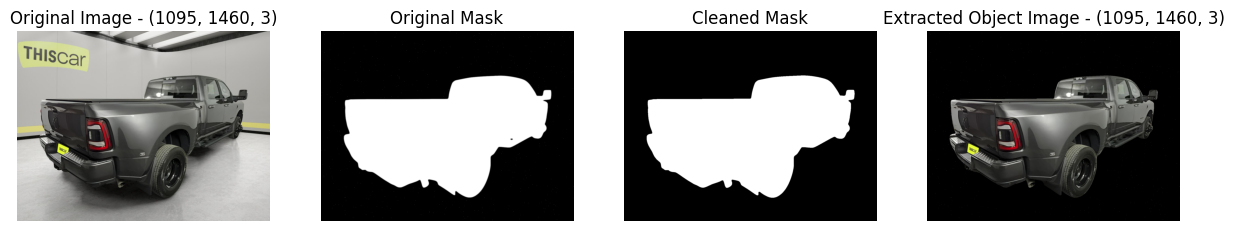

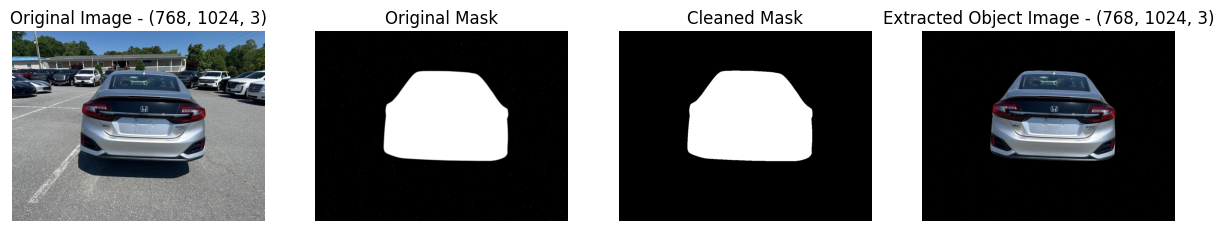

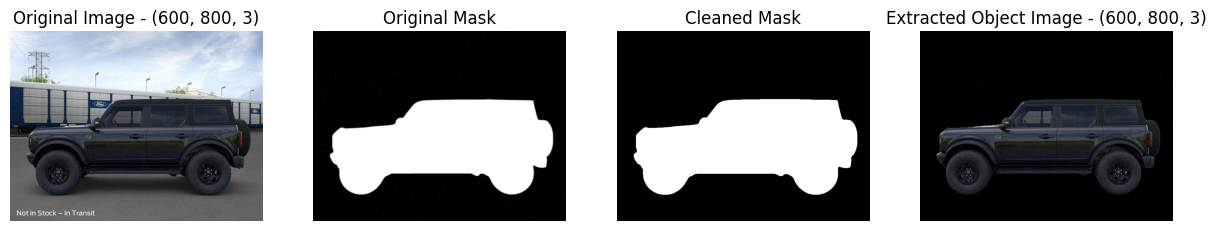

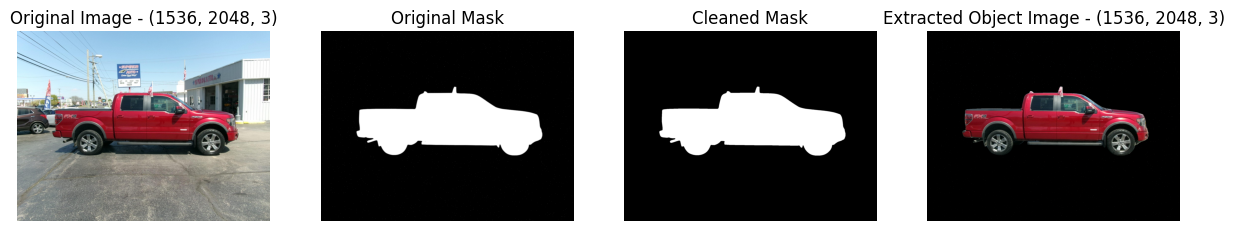

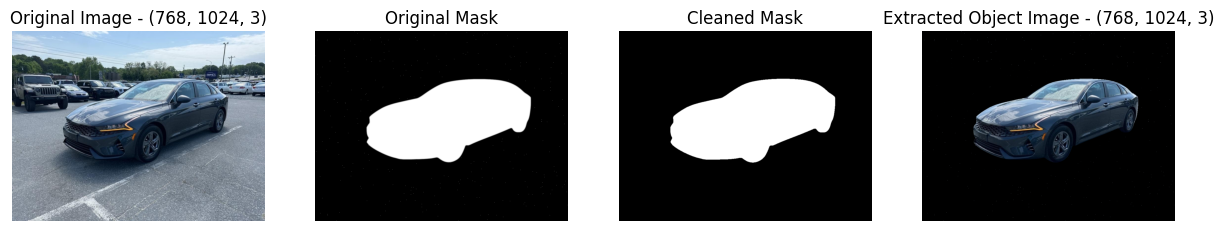

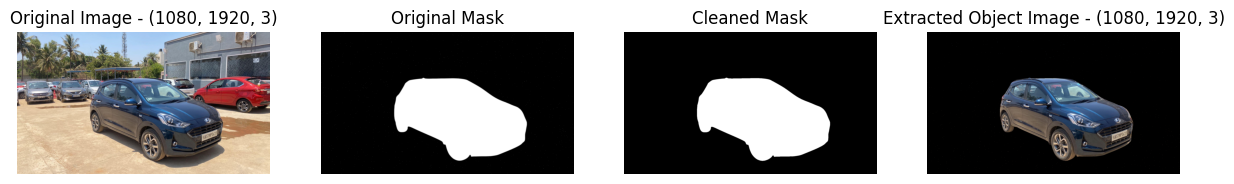

In [20]:
for i in range(6):
    image = cv2.imread(IMAGES_DIR/f"{i+1}.jpeg")
    mask = cv2.imread(MASKS_DIR/f"{i+1}.png", cv2.IMREAD_GRAYSCALE)

    extract_car_image(image, mask)

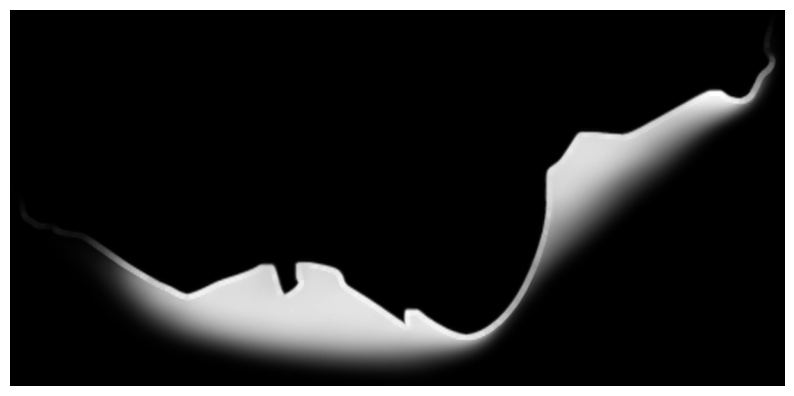

In [21]:
shadow_mask = cv2.imread(SHADOWS_DIR/"1.png", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10,10))
plt.imshow(shadow_mask, cmap='gray')
plt.axis('off')
plt.show()

In [22]:
print(shadow_mask.shape)

(542, 1116)


In [23]:
floor = cv2.imread('./data/floor.png')
wall = cv2.imread('./data/wall.png')

print(floor.shape)
print(wall.shape)

(2160, 3840, 3)
(2160, 3840, 3)


In [24]:
def add_shadow_to_car(car_image, shadow_mask, intensity=0.5):
    # Resize shadow mask to match car size
    shadow_mask_resized = cv2.resize(shadow_mask, (car_image.shape[1], car_image.shape[0]))
    
    # Create a darkening layer
    shadow_layer = np.ones_like(car_image) * 255
    shadow_layer[shadow_mask_resized > 0] = [0, 0, 0]
    
    # Blend the shadow with the car
    return cv2.addWeighted(car_image, 1, shadow_layer, intensity, 0)

In [2]:
import os
from pathlib import Path

import cv2
import numpy as np

DATA_ROOT = Path('./data')

IMAGES_ROOT = DATA_ROOT / 'images'
MASKS_DIR = DATA_ROOT / 'car_masks'
SHADOW_DIR = DATA_ROOT / 'shadow_masks'

def load_image_and_masks(image_path):
    '''
    Loads an image and its corresponding masks.
    '''
    image_name = image_path.stem
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    mask = cv2.imread(MASKS_DIR / f'{image_name}.png', cv2.IMREAD_GRAYSCALE)
    shadow_mask = cv2.imread(SHADOW_DIR / f'{image_name}.png', cv2.IMREAD_GRAYSCALE)
    return image, mask, shadow_mask

def clean_mask(mask, kernel_size=7):
    '''
    Cleans noise from binary masks.
    Inputs:
        mask(np.ndarray): Original mask to process
        kernel_size(int): Size of the kernels for morphological operations
    Output:
        mask(np.ndarray): Processed binary mask with noise and holes removal
    '''
    _, binary_mask = cv2.threshold(mask, 0.498, 1, cv2.THRESH_BINARY)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel) # morphological opening to remove small noise (isolated pixels)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel) # morphological closing to remove small holes
    binary_mask = cv2.medianBlur(binary_mask, ksize=5)
    return binary_mask

def detect_background(image, axis=1):
    '''
    Detects the starting and ending rows of wall/floor in the image.
    '''
    # Check if the image has an alpha channel
    if image.shape[2] == 4:
        # Use alpha channel for detection
        non_transparent = image[:, :, 3] > 0
    else:
        # For RGB images, detect non-white pixels
        non_white = np.any(image != [255, 255, 255], axis=2)
    
    non_empty_rows = np.where(np.any(non_transparent if image.shape[2] == 4 else non_white, axis=axis))[0]
    if len(non_empty_rows) == 0:
        return None  # No ROI detected
    
    start_row = non_empty_rows[0]
    end_row = non_empty_rows[-1]
    
    return start_row, end_row

def extract_car(car_image, car_mask):
    cleaned_mask = clean_mask(car_mask)
    car_image = cv2.bitwise_and(car_image, car_image, mask=cleaned_mask)
    return car_image

def create_background(floor_image, wall_image):
    start_row_floor, end_row_floor = detect_background(floor_image)
    _, end_row_wall = detect_background(wall_image)
    background = np.vstack((wall_image[int(end_row_wall-0.7*end_row_wall):end_row_wall], floor_image[start_row_floor:end_row_floor]))
    return background

def compose_image(car_image, car_mask, background):
    extracted_car = extract_car(car_image, car_mask)
    
    # Get dimensions
    car_height, car_width = extracted_car.shape[:2]
    bg_height, bg_width = background.shape[:2]
    
    # Calculate position to place car at the center
    x_offset = (bg_width - car_width) // 2
    y_offset = (bg_height - car_height) // 2
    
    # Create a region of interest (ROI) in the background
    roi = background[y_offset:y_offset+car_height, x_offset:x_offset+car_width]
    
    # Create a mask of the car and its inverse
    car_gray = cv2.cvtColor(extracted_car, cv2.COLOR_BGR2GRAY)
    _, car_mask = cv2.threshold(car_gray, 1, 255, cv2.THRESH_BINARY)
    car_mask_inv = cv2.bitwise_not(car_mask)
    
    # Black-out the area of car in ROI
    bg_roi = cv2.bitwise_and(roi, roi, mask=car_mask_inv)
    
    # Take only region of car from car image
    car_fg = cv2.bitwise_and(extracted_car, extracted_car, mask=car_mask)
    
    # Put car in ROI and modify the background
    dst = cv2.add(bg_roi, car_fg)
    background[y_offset:y_offset+car_height, x_offset:x_offset+car_width] = dst
    
    return background

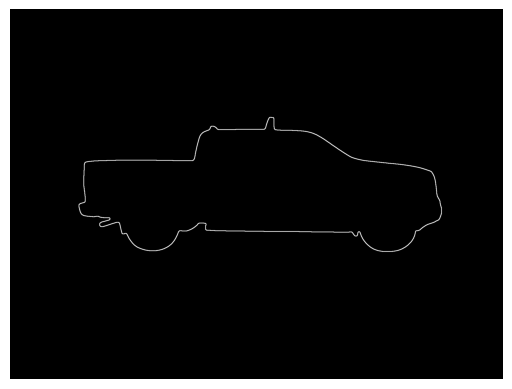

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

car_mask = cv2.imread("./data/car_masks/4.png", cv2.IMREAD_GRAYSCALE)
shadow_mask = cv2.imread("./data/shadow_masks/4.png", cv2.IMREAD_GRAYSCALE)

def clean_mask(mask, kernel_size=7):
    _, binary_mask = cv2.threshold(mask, 0.498, 1, cv2.THRESH_BINARY)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel) # morphological opening to remove small noise (isolated pixels)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel) # morphological closing to remove small holes
    binary_mask = cv2.medianBlur(binary_mask, ksize=5)
    return binary_mask

car_mask = clean_mask(car_mask)

car_contours, _ = cv2.findContours(car_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(np.zeros_like(car_mask), car_contours, -1, (255), 2)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

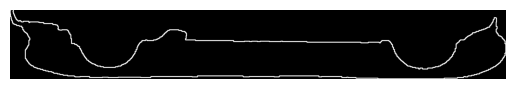

In [17]:
shadow_contours, _ = cv2.findContours(shadow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(np.zeros_like(shadow_mask), shadow_contours, -1, (255), 2)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

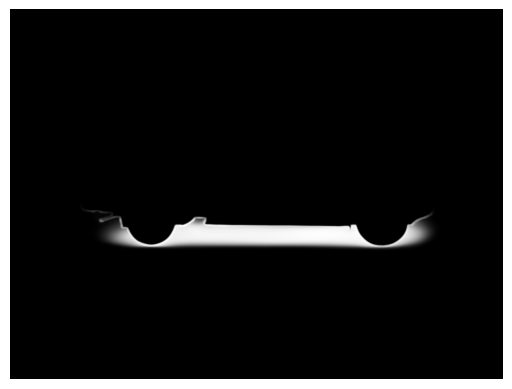

In [18]:
def align_shadow(object_mask, shadow_mask):
    """Align the shadow mask with the object using contours."""
    # Find contours of the object
    object_contours, _ = cv2.findContours(object_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the largest contour (assuming it's the car)
    largest_contour = max(object_contours, key=cv2.contourArea)
    
    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Resize the shadow mask to match the width of the object
    shadow_resized = cv2.resize(shadow_mask, (w, shadow_mask.shape[0]))
    
    # Create a blank mask the same size as the object mask
    aligned_shadow = np.zeros_like(object_mask)
    
    # Calculate the vertical position to place the shadow (at the bottom of the object)
    shadow_y = y + h - shadow_resized.shape[0]
    
    # Place the resized shadow in the correct position
    aligned_shadow[shadow_y:shadow_y+shadow_resized.shape[0], x:x+w] = shadow_resized
    
    return aligned_shadow

aligned_shadow = align_shadow(car_mask, shadow_mask)
plt.imshow(aligned_shadow, cmap='gray')
plt.axis('off')
plt.show()

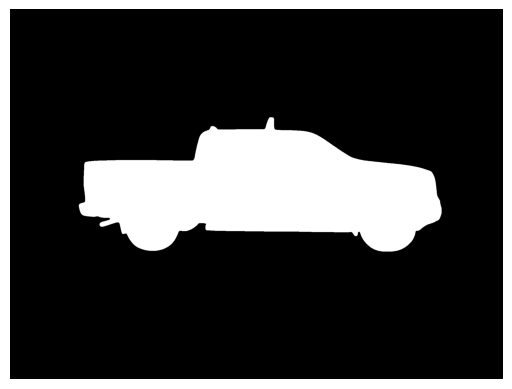

In [19]:
plt.imshow(car_mask, cmap='gray')
plt.axis('off')
plt.show()

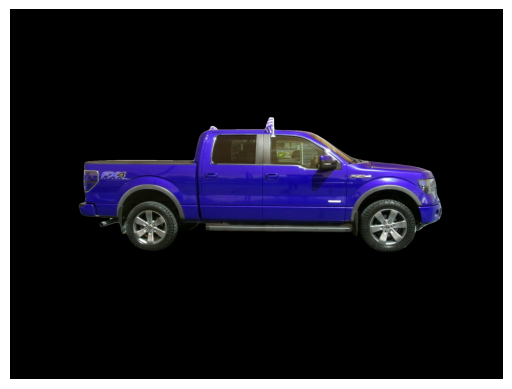

In [20]:
car_img = cv2.imread("./data/images/4.jpeg")
car_img_extracted = cv2.bitwise_and(car_img, car_img, mask=car_mask)
plt.imshow(car_img_extracted)
plt.axis('off')
plt.show()

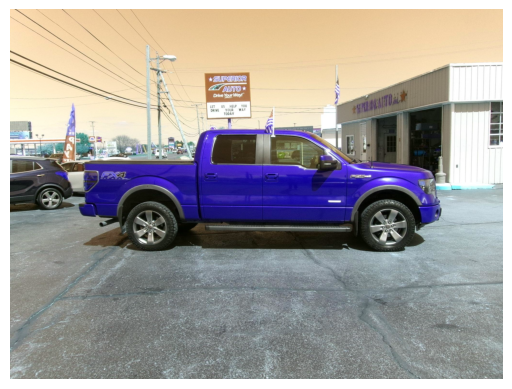

In [23]:
def apply_shadow(image, shadow_mask):
    """Apply shadow to the image using the aligned shadow mask."""
    # Normalize the shadow mask
    shadow_mask = shadow_mask.astype(float) / 255.0
    
    # Apply shadow by darkening the image
    darkened = image.astype(float) * 1  # Adjust darkening factor as needed
    shadowed = image.astype(float) * (1 - shadow_mask[:,:,np.newaxis]) + darkened * shadow_mask[:,:,np.newaxis]
    return shadowed.astype(np.uint8)

shadowed_car = apply_shadow(car_img, aligned_shadow)
plt.imshow(shadowed_car)
plt.axis('off')
plt.show()

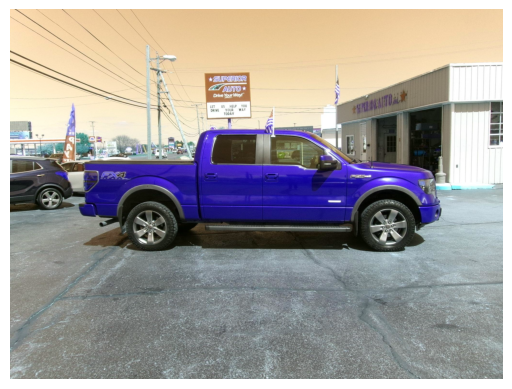

In [22]:
plt.imshow(car_img)
plt.axis('off')
plt.show()